# 04-Extraction of Points of Interests around Schools

From previous notebooks, we got the complete list of schools, their geographical coordinates and the related map. It would be interesting to explore the neighbourhood around a school in terms of points of interests: places to eat, green areas, culture places (library, museums etc), bus and train stations, places to practice sport, healthcare related buildings and utilities (for printing or for drinking water).

## Loading PBF file

In [42]:
# Libraries to import
from folium.plugins import Search
import numpy as np
import pandas as pd
import pygeos
import pyrosm
import matplotlib.pyplot as plt
import geopandas as gpd
import folium
import requests
import plotly.express as px
import os
import osmnx as ox
import datetime
import branca
import requests
import zipfile
import io
from itertools import islice
import json


From ISTAT's website we can download administrative boundaries of Trentino and extract the zip file obtained. 

In [43]:
# If data is not downloaded yet, request from ISTAT
if not os.path.exists('../data/Limiti01012021_g'):
    # download the data
    zip_file_url = 'https://www.istat.it/storage/cartografia/confini_amministrativi/generalizzati/Limiti01012021_g.zip'
    # request the file
    r = requests.get(zip_file_url, verify=False)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    # unzip the file
    z.extractall("../data/")

Let's save the PBF file about Trentino inside data directory. It will be necessary for calling `pyrosm.OSM`. [Pyrosm](https://pyrosm.readthedocs.io/en/latest/) is a Python library for reading OpenStreetMap from Protocolbuffer Binary Format files, with extension `*.osm.pbf`, into Geopandas GeoDataFrames. 

In [44]:
trento_download_pbf_url = "https://osmit-estratti.wmcloud.org/dati/poly/province/pbf/022_Provincia%20di%20Trento_poly.osm.pbf"
# download the data
# request the file
r = requests.get(trento_download_pbf_url, allow_redirects=True)
# save the file
open('../data/trento.pbf', 'wb').write(r.content)

41889892

In [45]:
# Initialize the OSM object
osm = pyrosm.OSM("../data/trento.pbf")

## Searching for Points of Interest (POI)
The following dictionary filters all the attractions to which we're instered in. In particular, amenities, shops, tourism, leisure and sport places. Based on this filter, we can get all points of interest within Trentino's territory through `osm.get_pois()`.

In [46]:
custom_filter = {'amenity': True,
                 'shop': True,
                 'tourism': True,
                 'leisure': True,
                 'sport': True}
pois = osm.get_pois(custom_filter)

C:\Users\auror\anaconda3\envs\geospatial\lib\site-packages\pyrosm\pyrosm.py:576: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  gdf = get_poi_data(


In [47]:
pois

,changeset,id,tags,lat,timestamp,version,lon,addr:city,addr:country,addr:full,...,pub,spa,boat,caravan,furniture,pet,artwork,pitch,sauna,camp_site
0,0.0,26859342,"{""fee"":""yes"",""power_supply"":""yes"",""sanitary_du...",46.166386,1629616433,4,10.749870,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,26859416,None,45.881302,1424078139,4,10.862040,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,26859590,"{""alt_name"":""Campeggio Laghi di Lamar"",""name:e...",46.111111,1628612842,3,11.048056,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,26859597,"{""currency:XBT"":""yes"",""payment:bitcoin"":""yes"",...",46.007778,1553152358,3,11.284722,Levico Terme,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,26859712,None,45.780357,1357636848,4,10.945409,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50582,0.0,35782641854,"{""fax"":""0463/467616"",""isced:level"":""1;2"",""type...",NaN,1642192813,2,NaN,None,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50583,0.0,37209968649,"{""type"":""multipolygon""}",NaN,1645298770,1,NaN,Calliano,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50584,0.0,39460445790,"{""fee"":""no"",""type"":""multipolygon""}",NaN,1647338423,1,NaN,None,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50585,0.0,39585903727,"{""denomination"":""catholic"",""type"":""multipolygo...",NaN,1648129534,1,NaN,None,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## POIs Processing
OSM returns a lot of columns and most of them are useless. In the following chunk, only useful columns are considerated: coordinates and geometry, name, contact information, opening hours (when available) and category, divided over amenity, shop, tourism and leisure columns. These four columns are then mixed up inside category column.

In [48]:
pois = pois[['lat', 'lon', 'name', 'amenity', 'shop', 'tourism',
             'leisure', 'opening_hours', 'phone', 'website',
             'internet_access', 'geometry']]

pois['category'] = pois['amenity'].fillna(pois['shop']).fillna(
    pois['tourism']).fillna(pois['leisure'])
pois.drop(['amenity', 'shop', 'tourism', 'leisure'], axis=1, inplace=True)

C:\Users\auror\anaconda3\envs\geospatial\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\auror\anaconda3\envs\geospatial\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [49]:
pois

,lat,lon,name,opening_hours,phone,website,internet_access,geometry,category
0,46.166386,10.749870,Camping Parco Adamello,None,None,None,None,POINT (10.74987 46.16639),camp_site
1,45.881302,10.862040,Camping Brione,None,+39 0464 520885,http://www.campingbrione.com/,None,POINT (10.86204 45.88130),camp_site
2,46.111111,11.048056,Lamar,None,+39 0461 860423,http://www.laghidilar.com/,None,POINT (11.04806 46.11111),camp_site
3,46.007778,11.284722,Lago Levico Camping Village,None,None,https://www.campinglevico.com/,None,POINT (11.28472 46.00778),camp_site
4,45.780357,10.945409,Polsa,None,None,None,None,POINT (10.94541 45.78036),camp_site
...,...,...,...,...,...,...,...,...,...
50582,NaN,NaN,Istituto Comprensivo Taio,None,0463/468193,None,None,"MULTIPOLYGON (((11.06985 46.32204, 11.06937 46...",school
50583,NaN,NaN,Prato Verde,None,None,http://pratoverde.tn.it/,None,"MULTIPOLYGON (((11.09682 45.93542, 11.09720 45...",garden_centre
50584,NaN,NaN,None,None,None,None,None,"POLYGON ((11.18644 46.19043, 11.18650 46.19068...",parking
50585,NaN,NaN,chiesa di San Pancrazio,None,None,None,None,"POLYGON ((11.01402 45.89675, 11.01430 45.89668...",place_of_worship


Since there are hundreds of categories, we need to filter them and make them fit inside some specific categories: Food, Healthcare, Sport, Culture, Utilities and Outdoor. The classification has been done manually, looking over all types of amenities found by OSM. The category in which places fit in are saved in type column and then the dataframe is filtered, considering just the rows whose category fits within those siz we established. The complete list of categories can be found in the following chunk:

In [50]:
list(set(pois['category']))

['public_building',
 'pasta',
 'beverages',
 'baby_goods',
 'tanning_salon',
 'dive_centre',
 'logistics',
 'planetarium',
 'post_box',
 'recreation_ground',
 'tableware',
 'motorcycle_repair',
 'newsagent;tobacco;hemp;',
 'trade',
 'music_school',
 'appliance',
 'bakery',
 'golf_course',
 'bike grill',
 'bbq',
 'artwork',
 'scooter_rental',
 'photos',
 'letter_box',
 'garden_furniture',
 'eiderdowns_duvets;quilts',
 'fuel',
 'gas',
 'houseware',
 'Outdoor_Consultant',
 'bandstand',
 'car',
 'clothes',
 'hardware',
 'photo_studio',
 'woodshed',
 'deli',
 'restaurant;bar',
 'marketplace',
 'information',
 'playground',
 'animal_shelter',
 'festival_ground',
 'amusement_arcade',
 'hospital',
 'tailor',
 'bicycle_parking',
 'pathway',
 'college',
 'mobile_phone',
 'club',
 'department_store',
 'outdoor_seating',
 'coffee_roasting',
 'ski_school',
 'agricultural_vehicle',
 'car;car_repair',
 'animal_breeding',
 'slipway',
 'gift',
 'charging_station',
 'bench',
 'antiques',
 'dance',
 'fir

Also, since some places' geometry is a polygon and not a single point, we pick up their representative point:

In [51]:
def categorize(type):
    if type in ['bar', 'cafe', 'restaurant', 'restaurant;bar',
                'restaurant;cafe', 'fast_food', 'food_court',
                'ice_cream', 'supermarket', 'bakery',
                'greengrocer', 'mall', 'marketplace']:
        return "Food"
    elif type in ['clinic', 'dentist', 'doctors',
                  'hospital', 'pharmacy']:
        return "Healthcare"
    elif type in ['training', 'gym', 'ski_school', 'sailing_school', 'aquatics_centre',
                  'dive_centre', 'horse_riding', 'fitness_centre', 'fitness_station', 'ice_rink',
                  'dojo', 'pitch', 'schoolyard', 'stadium', 'swimming_area', 'swimming_pool']:
        return "Sport"
    elif type in ['theatre', 'museum', 'arts_centre', 'gallery',
                  'cinema', 'library', 'zoo', 'planetarium', 'artwork', 'books',
                  'music_school', 'music_venue', 'public_bookcase']:
        return "Culture"
    elif type in ["typography", 'tipography', 'drinking_water',
                  'stationery', 'copyshop', 'printing', 'stationery']:
        return "Utilities"
    elif type in ['outdoor_seating', 'park', 'picnic_site', 'picnic_table']:
        return "Outdoor"
    else:
        return ""


# Apply category to each type of amenity
pois['type'] = [categorize(x) for x in pois['category']]

# Remove amenities with no type
pois = pois[pois['type'] != ""]

# Convert polygons into points, by collecting only its representative
pois['geometry'] = pois['geometry'].representative_point()

C:\Users\auror\anaconda3\envs\geospatial\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\auror\anaconda3\envs\geospatial\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


We can try to plot these points on the map, coloured by category. Most of them are placed in Trento, Riva del Garda and Rovereto, the most populated areas. 

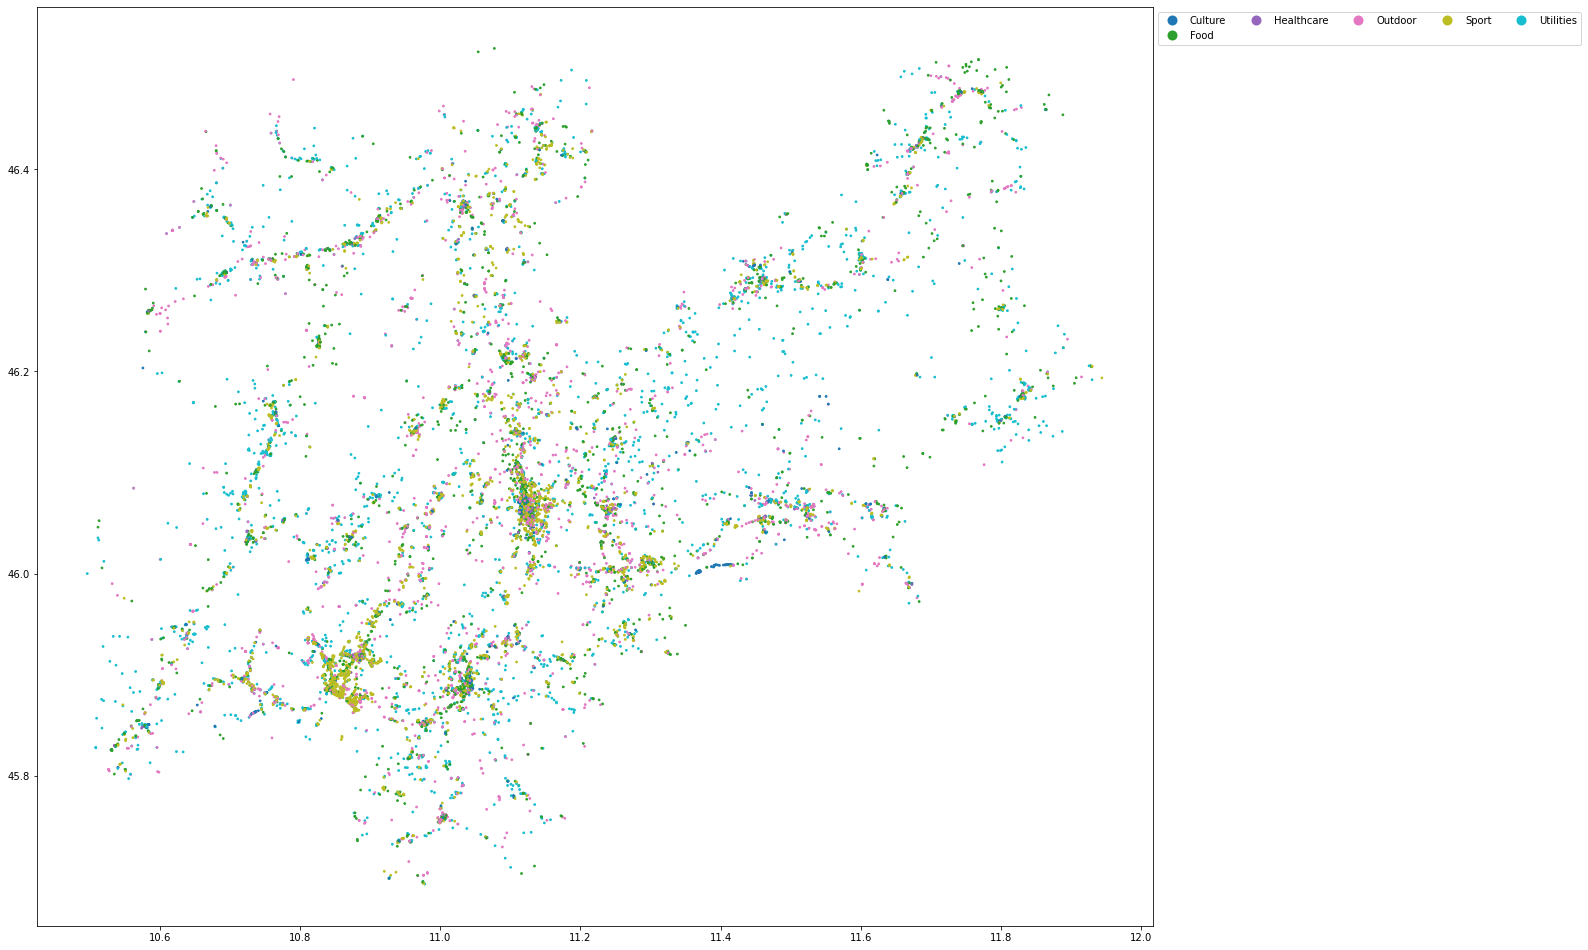

In [52]:
# Plot
ax = pois.plot(column='type', markersize=3, figsize=(20, 20), legend=True,
               legend_kwds=dict(loc='upper left', ncol=5, bbox_to_anchor=(1, 1)))
plt.show()

There is one missing category from the POIs collected: transports. In the morning to go to school, in the afternoon to go back home or move around the territory. They play a key role when choosing a school and when evaluating its connectivity with the rest of the territory, especially with those amenities of interest around schools that may be useful for students, such as places where to eat, study, play sport etc. 

In Transports, we will consider both train stations (whose data is collected from Trenitalia) and bus stops (whose data is collected from TrentinoTrasporti), both urban and extraurban. Of these stations/stops, we will save name and geographical coordinates, which will be saved inside a Geodataframe called transports that will be concatenated to pois. 

In [53]:
# Import bus and train stations
# Train stations
train_stations = pd.read_csv(
    "../data/Trentino/transports/trenitalia_stations.csv")
train_stations = gpd.GeoDataFrame(train_stations,
                                  geometry=gpd.points_from_xy(train_stations.lon,
                                                              train_stations.lat))

train_stations.rename(columns={'Stazione': 'name'}, inplace=True)
train_stations = train_stations[['name', 'lat', 'lon']]
train_stations['type'] = "Transports"
train_stations['category'] = "train"

# Bus stops
bus_stops = pd.read_csv("../data/Trentino/transports/urban_stops.txt")
bus_stops_2 = pd.read_csv("../data/Trentino/transports/extraurban_stops.txt")
bus_stops_2['wheelchair_boarding'] = np.nan
bus_stops = pd.concat([bus_stops, bus_stops_2])
bus_stops = bus_stops[['stop_name', 'stop_lat', 'stop_lon']]
bus_stops.rename(columns={'stop_name': 'name',
                          'stop_lat': 'lat',
                          'stop_lon': 'lon'}, inplace=True)
bus_stops['type'] = "Transports"
bus_stops['category'] = "bus"

transports = pd.concat([train_stations, bus_stops])
transports = gpd.GeoDataFrame(transports,
                              geometry=gpd.points_from_xy(transports.lon,
                                                          transports.lat))

pois = pd.concat([pois, transports])

## Schools' neighbourhood

Now we hold POIs of the entire Trentino Province. Since there are too many and the map would be hard to load, it has been chosen to create a POIs map for each school, inside a buffer range of 1km. 

In [54]:
schools = gpd.read_file("../data/Trentino/schools/schools.geojson", crs=4326)

schools['neighbour'] = schools['geometry'].to_crs(
    32632).buffer(1000).to_crs(4326)

In [55]:
schools

,index,Id Istituto,Id,Nome,lat,lon,Istituto,Tipo Istituto,Gestione,Indirizzo,Comune,Telefono,Fax,Email istituto,Email segreteria,Sito web,Codice MIUR,CAP,geometry,neighbour
0,0,0222055913,0222057135,Liceo Linguistico,46.059356,11.121925,"Liceo Linguistico ""S. M. Scholl"" - Trento",Scuola Secondaria di Secondo Grado,Statale,"Via Mattioli, 8",Trento,0461914499,0461915472,linguisticotrento@pec.provincia.tn.it,segr.linguisticotrento@scuole.provincia.tn.it,www.linguisticotrento.it,TNPS11000Q,38122,POINT (11.12192 46.05936),"POLYGON ((11.13484 46.05912, 11.13475 46.05823..."
1,1,0222059503,0222055406,Istituto Tecnico Per Il Settore Economico Serale,46.065537,11.129403,"Istituto Tecnico Economico ""A. Tambosi"" - Trento",Scuola Secondaria di Secondo Grado,Statale,"Via Brigata Acqui, 19",Trento,0461239955,0461230175,tambosibattisti@pec.provincia.tn.it,segr.tambositn@scuole.provincia.tn.it,http://tambosi.tn.it,TNTD180507,38122,POINT (11.12940 46.06554),"POLYGON ((11.14232 46.06529, 11.14223 46.06441..."
2,2,0222059503,0222055431,Istituto Tecnico Per Il Settore Economico,46.065537,11.129403,"Istituto Tecnico Economico ""A. Tambosi"" - Trento",Scuola Secondaria di Secondo Grado,Statale,"Via Brigata Acqui, 19",Trento,0461239955,0461230175,tambosibattisti@pec.provincia.tn.it,segr.tambositn@scuole.provincia.tn.it,http://tambosi.tn.it,TNTD18000T,38122,POINT (11.12940 46.06554),"POLYGON ((11.14232 46.06529, 11.14223 46.06441..."
3,3,0222222901,0222223001,"Scuola Secondaria Di Primo Grado ""A. Frank"" Vi...",45.918206,11.031039,Istituto Comprensivo Villa Lagarina,Scuola Secondaria di Primo Grado,Statale,"Via Stockstadt Am Rhein, 3",Villa Lagarina,0464/411312,0464/411705,ic.villalagarina@pec.provincia.tn.it,segr.ic.villalagarina@scuole.provincia.tn.it,www.icvillalagarina.it,TNMM846015,38060,POINT (11.03104 45.91821),"POLYGON ((11.04393 45.91798, 11.04383 45.91710..."
4,4,0222222901,0221442101,"Scuola Primaria ""R. Galvagni"" Pomarolo",45.928203,11.042493,Istituto Comprensivo Villa Lagarina,Scuola Primaria,Statale,"Piazzale Colonello Angheben, 5",Pomarolo,0464/411312,0464/411705,ic.villalagarina@pec.provincia.tn.it,segr.ic.villalagarina@scuole.provincia.tn.it,www.icvillalagarina.it,TNEE846027,38060,POINT (11.04249 45.92820),"POLYGON ((11.05538 45.92797, 11.05529 45.92709..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
718,718,None,None,Scuola Dell'Infanzia Di Trento Piedicastello,46.071740,11.114170,Circolo Di Coordinamento N. 5,Scuola dell'Infanzia,Statale,"Via Dos Trento, 86",Trento,0461/983539,0461/497257,scuolainfanzia.piedicastello@scuole.provincia....,circolo.coordinamento05@provincia.tn.it,None,None,38122,POINT (11.11417 46.07174),"POLYGON ((11.12709 46.07150, 11.12700 46.07062..."
719,719,None,None,"Scuola Dell'Infanzia Di Tierno Mori ""Il Giras...",45.845660,10.979920,Circolo Di Coordinamento N. 9,Scuola dell'Infanzia,Statale,"Via della Cooperazione, 20",Mori,0464/917200,0464/493117,scuolainfanzia.tierno@scuole.provincia.tn.it,circolo.coordinamento09@provincia.tn.it,None,None,38065,POINT (10.97992 45.84566),"POLYGON ((10.99279 45.84544, 10.99270 45.84456..."
720,720,None,None,"Scuola Dell'Infanzia Di Pellizzano ""Antonio Bo...",46.309630,10.759200,Circolo Di Coordinamento N. 11,Scuola dell'Infanzia,Statale,"Via Dei Baschenis, 3",Pellizzano,335 1817040,0461/491940,scuolainfanzia.pellizzano@scuole.provincia.tn.it,circolo.coordinamento11@provincia.tn.it,None,None,38020,POINT (10.75920 46.30963),"POLYGON ((10.77218 46.30943, 10.77209 46.30855..."
721,721,None,None,Scuola Dell'Infanzia Di Tesero,46.289560,11.514970,Scuola Dell'Infanzia Di Tesero,Scuola dell'Infanzia,Paritaria,"Via Fia, 20",Tesero,0462-813045,None,tesero.presidente@fpsm.tn.it,tesero.segretario@fpsm.tn.it,None,None,38038,POINT (11.51497 46.28956),"POLYGON ((11.52794 46.28927, 11.52784 46.28839..."


The POIs inside pois dataset consider the entire territory, while schools' neighbourhood is restricted to a smaller area. We will therefore subset the pois dataset considering all the POIs within schools' area. 

In [56]:
# Get only POIs within the buffers
pois = pois.reset_index(drop=True)

schools_neighbour = gpd.GeoDataFrame(schools['neighbour'],
                                     geometry=schools['neighbour'],
                                     crs=4326).dissolve(aggfunc=sum)

selection = []
from tqdm import tqdm
for i in tqdm(range(len(pois))):
    if pois.loc[i, 'geometry'].within(schools_neighbour['geometry'][0]):
        selection.append(i)

selection = list(set(selection))
pois = pois.iloc[selection].reset_index(drop=True)

C:\Users\auror\anaconda3\envs\geospatial\lib\site-packages\pandas\core\apply.py:169: FutureWarning: Dropping invalid columns in DataFrameGroupBy.add is deprecated. In a future version, a TypeError will be raised. Before calling .add, select only columns which should be valid for the function.
  return getattr(obj, f)()
100%|██████████| 16268/16268 [00:48<00:00, 334.80it/s]


## POIs map

At this point, we hold the complete pois dataset and we can create the maps. The following chunk contains a dictionary for mapping each category to a symbol, a culture and an italian label in the map. Also, the file named `traduzioni.json` will help us to traduce all the specific categories of places to their respective term in italian. 

In [57]:
icons = {
    'Culture': {'icon': 'university', 'color': 'pink', 'name': 'Cultura'},
    'Transports': {'icon': 'bus', 'color': 'lightblue', 'name': 'Trasporti'},
    'Utilities': {'icon': 'wrench', 'color': 'lightgray', 'name': 'Utilità'},
    'Food': {'icon': 'cutlery', 'color': 'lightred', 'name': 'Ristorazione'},
    'Healthcare': {'icon': 'medkit', 'color': 'lightgreen', 'name': 'Salute'},
    'Sport': {'icon': 'bicycle', 'color': 'orange', 'name': 'Sport'},
    'Outdoor': {'icon': 'tree', 'color': 'green', 'name': 'Aree verdi'}
}

with open("../data/traduzioni.json","r", encoding='utf-8') as f:
    traduction = json.load(f)

pois = pois.fillna(np.nan).replace([np.nan], [None])

We can inspect the first 10 elements inside `traduzioni.json`:

In [58]:
def take(n, iterable):
    # Return first n items of the iterable as a list
    return list(islice(iterable, n))

take(10, traduction.items())

[('aquatics_centre', 'Centro acquatico'),
 ('arts_centre', 'Centro artistico'),
 ('artwork', "Opera d'arte"),
 ('bakery', 'Panificio'),
 ('bar', 'Bar'),
 ('books', 'Libreria'),
 ('bus', 'Fermata del bus'),
 ('cafe', 'Bar'),
 ('cinema', 'Cinema'),
 ('clinic', 'Clinica medica')]

Our aim is to build a map with a school's Marker at the centre, its buffer for 1km and all the points of interest within this buffer, coloured by the category they belong to. 

In order to do that, we're going to need some functions:

* `get_pois_within_buffer()` takes all the points of interest inside pois dataset within the buffer around the school;
* `generate_complete_popup()` and `generate_simple_popup()` generate the popup message for the school (more detailed) and the single point of interest (with opening hurs, phone, website, internet access, category, type, travel time and distance);
* `get_graph()`: starting from a single shapely point, we get the walking street graph using OSM network x (osmnx) package. In order to get travel time for each point of interest, it is necessary to call `ox.add_edge_speeds()` with some default speeds;
* `get_travel_time_distance()` finds the shortest path in terms of length (meters) and time (minutes and seconds estimated) from point 1 to point 2. It will be used to compute travel times from a school to any point of interest around it;
* `create_school_pois_map()` wraps all the previous functions together to generate a map with the school, its popup when clicking,the neighbourhood and the points of interest inside of it. 

In [59]:
"""
Get all the points of interest inside pois dataset that 
are within a 1km buffer around point p
"""
def get_pois_within_buffer(p, pois):
    # Getting the neighbour of the school
    buffer = p['neighbour']
    # Getting indexes of POIs around the school
    j = [i for i in range(len(pois)) if pois.loc[i, 'geometry'].within(buffer)]
    return pois.iloc[j]

In [60]:
"""
Generate the html popup of the school with its details
    @row: row of the schols dataframe 
"""
def generate_complete_popup(row):
    # Open the HTML popup table
    text = """
        <!DOCTYPE html>
        <html>
            <meta charset="UTF-8">
            <style>
                @import url('https://fonts.googleapis.com/css2?family=Roboto:ital,wght@0,100;0,400;0,500;1,300;1,400;1,700&display=swap');
            </style>
            <h4 style="font-family: 'Roboto', sans-serif;">{}</h4>
            <table style="height: 150px; width: 280px; font-family: 'Roboto', sans-serif; padding:5px; word-wrap: break-all;">
            <tbody>
        """.format(row['Nome'])

    # Iterate over columns
    for c in ['Istituto', 'Tipo Istituto', 'Gestione',
              'Indirizzo', 'Comune', 'CAP', 'Telefono', 'Fax',
              'Email istituto', 'Email segreteria', 'Sito web']:

        # If the value is Null, don't insert it in the table
        if row[c] != None:
            if c in ['Sito web']:
                # Insertion of clickable links
                text = text + """
                <tr>
                    <td><b>{}</b></td>
                    <td style="word-break: break-all; padding: 0 10px 0 0;"><a href = "https://{}" target="_blank">{}</a></td>""".format(c, row[c], row[c]) + """
                </tr>
                """
            elif c in ['Telefono', 'Fax']:
                # Insertion of clickable links
                text = text + """
                <tr>
                    <td><b>{}</b></td>
                    <td><a href = "tel:{}" target="_blank">{}</a></td>""".format(c, row[c], row[c]) + """
                </tr>
                """
            elif 'Email' in c:
                # Insertion of clickable links
                text = text + """
                <tr>
                    <td><b>{}</b></td>
                    <td><a href = "mailto:{}" target="_blank">{}</a></td>""".format(c, row[c], row[c]) + """
                </tr>
                """
            else:  # No need for links
                text = text + """
                    <tr>
                        <td><b>{}</b></td>
                        <td>{}</td>""".format(c, row[c]) + """
                    </tr>
                """

    # Close the table
    text = text + """
            </tbody>
            </table>
        </html>
        """
    return text

In [61]:
"""
Generate a popup for points of interest with information
when available, such as opening hours, phone, website etc.
"""
def generate_simple_popup(row):
    # Open the HTML popup table
    if row['name'] != None:
        header = row['name']
    else:
        header = traduction[row['category']]
    
    text = """
        <!DOCTYPE html>
        <html>
            <meta charset="UTF-8">
            <style>
                @import url('https://fonts.googleapis.com/css2?family=Roboto:ital,wght@0,100;0,400;0,500;1,300;1,400;1,700&display=swap');
            </style>
            <h4 style="font-family: 'Roboto', sans-serif;">{}</h4>
            <table style="width: 160px; font-family: 'Roboto', sans-serif;">
            <tbody>
        """.format(header)

    # Iterate over columns
    for c in ['opening_hours','phone','website','internet_access','category','type', 'time','distance']:
        # If the value is Null, don't insert it in the table
        if row[c] != None and row[c] != "nan":
            if c in ['website']:
                # Insertion of clickable links
                text = text + """
                <tr>
                    <td><b>{}</b></td>
                    <td style="word-break: break-all;"><a href = "https://{}" target="_blank">{}</a></td>""".format(traduction[c], row[c], row[c]) + """
                </tr>
                """
            elif c in ['phone']:
                # Insertion of clickable links
                text = text + """
                <tr>
                    <td><b>{}</b></td>
                    <td><a href = "tel:{}" target="_blank">{}</a></td>""".format(traduction[c], row[c], row[c]) + """
                </tr>
                """
            elif c in ['category','type']:
                text = text + """
                    <tr>
                        <td><b>{}</b></td>
                        <td>{}</td>""".format(traduction[c], traduction[row[c]]) + """
                    </tr>
                """                
            else:  # No need for links or traductions
                text = text + """
                    <tr>
                        <td><b>{}</b></td>
                        <td>{}</td>""".format(traduction[c], row[c]) + """
                    </tr>
                """

    # Close the table
    text = text + """
            </tbody>
            </table>
        </html>
        """
    return text

In [62]:
"""
Get the OSM networkX graph and the edges for computing 
travel time from a point to another (all considering walking streets)
"""
def get_graph(p):
    G = ox.graph_from_point((p.y, p.x), network_type='walk')
    hwy_speeds = {"residential": 35, "secondary": 50, "tertiary": 60}
    G = ox.add_edge_speeds(G,hwy_speeds=hwy_speeds)
    G = ox.add_edge_travel_times(G)
    return G

In [63]:
"""
Get travel time and distance in meters from point 1 to point 2
"""
def get_travel_time_distance(G, p1, p2):
    route = ox.shortest_path(G,
                            ox.nearest_nodes(G, p1.x, p1.y),
                            ox.nearest_nodes(G, p2.x, p2.y),
                            weight='length')
    seconds = sum(ox.utils_graph.get_route_edge_attributes(G, route, 'length'))
    distance = int(sum(ox.utils_graph.get_route_edge_attributes(G, route, "length")))
    time = str(datetime.timedelta(seconds=seconds)).split('.')[0][2:].split(":")
    return [str(int(time[0]))+" min "+str(int(time[1]))+" sec", str(distance)+"m"]

In [64]:
"""
Creation of a map centered around a school (p), with a buffer around and its
point of interest (pois), whose categories can be selected from the layer control,
together with the school and the neighbourhood circle. Also, popups are generated
for all markers. 
"""
def create_school_pois_map(p, pois, icons):
    # Get all POIs around the school
    pois = get_pois_within_buffer(p,pois)  
    pois = pois.reset_index(drop=True) 
    coords = p['geometry']
    G = get_graph(coords)
    pois[['time', 'distance']] = [get_travel_time_distance(G, coords,poi) for poi in pois['geometry']] 
    
    # Creation of the main map
    m = folium.Map(location=[coords.y, coords.x],
                             zoom_start=15, tiles=None)
    
    # Iterating over categories
    for name in set(pois['type']):
        # Feature Group
        fg = folium.FeatureGroup(name=traduction[name])
        fg.add_to(m)

        # Iterate over POIs
        for i in list(pois[pois['type'] == name].index):
            text = generate_simple_popup(pois.loc[i])
            iframe = branca.element.IFrame(html=text, width=200, height=60)
            popup = folium.Popup(folium.Html(text, script=True), max_width=200)
            folium.Marker(location=[pois.loc[i, 'geometry'].y,
                                    pois.loc[i, 'geometry'].x],
                        #popup = pois.loc[i,'name'],
                        icon=folium.map.Icon(prefix='fa',
                                            icon=icons[name]['icon'],
                                            color=icons[name]['color']),
                        popup = popup).add_to(fg)

    
    # Generation of popup information
    text = generate_complete_popup(p)
    iframe = branca.element.IFrame(html=text, width=300, height=280)
    popup = folium.Popup(folium.Html(text, script=True), max_width=300)
    
    # Insert the marker for the single school
    folium.Marker([coords.y, coords.x],
                icon=folium.map.Icon(prefix='fa',
                                    icon='graduation-cap',
                                    color="red"),
                popup=popup,
                name=p['Nome'],
                tooltip=p['Nome']).add_to(m)

    # Neighbourhoods around schools
    fg = folium.FeatureGroup(name="Dintorni")
    folium.GeoJson(p['neighbour'], style_function=lambda x: {'fillColor': '#fecc5cFF', 'color': '#fecc5cFF'}).add_to(fg)
    fg.add_to(m)

    # Adding layers
    folium.TileLayer("cartodbpositron", name="Light").add_to(m)
    folium.TileLayer("CartoDB dark_matter", name="Dark").add_to(m)
    folium.TileLayer('openstreetmap', name="OpenStreetMap").add_to(m)
    folium.LayerControl(collapsed=False).add_to(m)
    
    return m

Now we can use the function `create_school_pois_map()` to generate a map for every school inside the Province of Trentino and save them inside the viz directory. 

In [65]:
schools.set_index('index', inplace=True)

In [66]:
schools

,Id Istituto,Id,Nome,lat,lon,Istituto,Tipo Istituto,Gestione,Indirizzo,Comune,Telefono,Fax,Email istituto,Email segreteria,Sito web,Codice MIUR,CAP,geometry,neighbour
index,,,,,,,,,,,,,,,,,,,
0,0222055913,0222057135,Liceo Linguistico,46.059356,11.121925,"Liceo Linguistico ""S. M. Scholl"" - Trento",Scuola Secondaria di Secondo Grado,Statale,"Via Mattioli, 8",Trento,0461914499,0461915472,linguisticotrento@pec.provincia.tn.it,segr.linguisticotrento@scuole.provincia.tn.it,www.linguisticotrento.it,TNPS11000Q,38122,POINT (11.12192 46.05936),"POLYGON ((11.13484 46.05912, 11.13475 46.05823..."
1,0222059503,0222055406,Istituto Tecnico Per Il Settore Economico Serale,46.065537,11.129403,"Istituto Tecnico Economico ""A. Tambosi"" - Trento",Scuola Secondaria di Secondo Grado,Statale,"Via Brigata Acqui, 19",Trento,0461239955,0461230175,tambosibattisti@pec.provincia.tn.it,segr.tambositn@scuole.provincia.tn.it,http://tambosi.tn.it,TNTD180507,38122,POINT (11.12940 46.06554),"POLYGON ((11.14232 46.06529, 11.14223 46.06441..."
2,0222059503,0222055431,Istituto Tecnico Per Il Settore Economico,46.065537,11.129403,"Istituto Tecnico Economico ""A. Tambosi"" - Trento",Scuola Secondaria di Secondo Grado,Statale,"Via Brigata Acqui, 19",Trento,0461239955,0461230175,tambosibattisti@pec.provincia.tn.it,segr.tambositn@scuole.provincia.tn.it,http://tambosi.tn.it,TNTD18000T,38122,POINT (11.12940 46.06554),"POLYGON ((11.14232 46.06529, 11.14223 46.06441..."
3,0222222901,0222223001,"Scuola Secondaria Di Primo Grado ""A. Frank"" Vi...",45.918206,11.031039,Istituto Comprensivo Villa Lagarina,Scuola Secondaria di Primo Grado,Statale,"Via Stockstadt Am Rhein, 3",Villa Lagarina,0464/411312,0464/411705,ic.villalagarina@pec.provincia.tn.it,segr.ic.villalagarina@scuole.provincia.tn.it,www.icvillalagarina.it,TNMM846015,38060,POINT (11.03104 45.91821),"POLYGON ((11.04393 45.91798, 11.04383 45.91710..."
4,0222222901,0221442101,"Scuola Primaria ""R. Galvagni"" Pomarolo",45.928203,11.042493,Istituto Comprensivo Villa Lagarina,Scuola Primaria,Statale,"Piazzale Colonello Angheben, 5",Pomarolo,0464/411312,0464/411705,ic.villalagarina@pec.provincia.tn.it,segr.ic.villalagarina@scuole.provincia.tn.it,www.icvillalagarina.it,TNEE846027,38060,POINT (11.04249 45.92820),"POLYGON ((11.05538 45.92797, 11.05529 45.92709..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
718,None,None,Scuola Dell'Infanzia Di Trento Piedicastello,46.071740,11.114170,Circolo Di Coordinamento N. 5,Scuola dell'Infanzia,Statale,"Via Dos Trento, 86",Trento,0461/983539,0461/497257,scuolainfanzia.piedicastello@scuole.provincia....,circolo.coordinamento05@provincia.tn.it,None,None,38122,POINT (11.11417 46.07174),"POLYGON ((11.12709 46.07150, 11.12700 46.07062..."
719,None,None,"Scuola Dell'Infanzia Di Tierno Mori ""Il Giras...",45.845660,10.979920,Circolo Di Coordinamento N. 9,Scuola dell'Infanzia,Statale,"Via della Cooperazione, 20",Mori,0464/917200,0464/493117,scuolainfanzia.tierno@scuole.provincia.tn.it,circolo.coordinamento09@provincia.tn.it,None,None,38065,POINT (10.97992 45.84566),"POLYGON ((10.99279 45.84544, 10.99270 45.84456..."
720,None,None,"Scuola Dell'Infanzia Di Pellizzano ""Antonio Bo...",46.309630,10.759200,Circolo Di Coordinamento N. 11,Scuola dell'Infanzia,Statale,"Via Dei Baschenis, 3",Pellizzano,335 1817040,0461/491940,scuolainfanzia.pellizzano@scuole.provincia.tn.it,circolo.coordinamento11@provincia.tn.it,None,None,38020,POINT (10.75920 46.30963),"POLYGON ((10.77218 46.30943, 10.77209 46.30855..."


In [67]:
# Generate map for all schools
for i in tqdm(list(schools.index)):
    create_school_pois_map(schools.iloc[i],pois,icons).save("../viz/pois/"+str(i)+".html")

100%|██████████| 723/723 [1:05:00<00:00,  5.40s/it]


## Barplot for comparisons

In order to evaluate the number of points of interest in a specific school's area, we can compare them, for each category, with the provincial and municipal mean through a barplot. 

For each school we get the POIs around, we count how many POIs there are divided per category (`count` column), then we create a column with the municipality (`Comune`) and school index. In the end, we will get a complete dataframe called `pois_number_df` with all schools, their municipality and amenity (School).The index column may need to connect the chosen school in the website (which has an id) and this plot.

In [68]:
# Single School
pois_number_df = pd.DataFrame()
for i in tqdm(range(len(schools))):
    pois_plot = get_pois_within_buffer(schools.iloc[i], pois)
    single_school = pois_plot.groupby(['type']).size().to_frame("count")
    single_school['place'] = [schools.loc[i, 'Nome']
                              for x in range(len(single_school))]
    single_school['Comune'] = [schools.loc[i, 'Comune']
                               for x in range(len(single_school))]
    single_school['index'] = i
    pois_number_df = pd.concat([pois_number_df, single_school])
pois_number_df['amenity'] = "School"

100%|██████████| 723/723 [05:04<00:00,  2.37it/s]


In [69]:
pois_number_df

,count,place,Comune,index,amenity
type,,,,,
Culture,39,Liceo Linguistico,Trento,0,School
Food,229,Liceo Linguistico,Trento,0,School
Healthcare,29,Liceo Linguistico,Trento,0,School
Outdoor,20,Liceo Linguistico,Trento,0,School
Sport,51,Liceo Linguistico,Trento,0,School
...,...,...,...,...,...
Healthcare,4,Scuola Dell'Infanzia Di Villa Lagarina,Villa Lagarina,722,School
Outdoor,5,Scuola Dell'Infanzia Di Villa Lagarina,Villa Lagarina,722,School
Sport,9,Scuola Dell'Infanzia Di Villa Lagarina,Villa Lagarina,722,School


Then, we have to add to the dataframe the mean values per municipality and the entire Trentino province, by grouping for `Comune` and `type`. In the end, we concatenate the dataframe obtained above with the two computed for municipalities and province. All categories' names are traduced into the italian version. 

In [70]:
# %%
# Entire municipality
municipality = pois_number_df.groupby(
    ['Comune', 'type']).mean().reset_index().set_index('type')
municipality['place'] = municipality['Comune']
municipality['amenity'] = "Municipality"
municipality.drop("index", axis=1, inplace=True)

# Entire province
province = pois_number_df.groupby(
    ['type']).mean().reset_index().set_index('type')
province['place'] = "Provincia di Trento"
province['amenity'] = "Province"
province.drop("index", axis=1, inplace=True)
pois_plot = pd.concat([pois_number_df, municipality, province])
pois_plot = pois_plot.reset_index()

# Traductions
pois_plot.replace("Culture","Cultura",inplace=True)
pois_plot.replace("Food","Ristorazione",inplace=True)
pois_plot.replace("Healthcare","Salute",inplace=True)
pois_plot.replace("Outdoor","Aree verdi",inplace=True)
pois_plot.replace("Transports","Trasporti",inplace=True)
pois_plot.replace("Utilities","Utilità",inplace=True)

In [71]:
pois_plot

,type,count,place,Comune,index,amenity
0,Cultura,39.000000,Liceo Linguistico,Trento,0.0,School
1,Ristorazione,229.000000,Liceo Linguistico,Trento,0.0,School
2,Salute,29.000000,Liceo Linguistico,Trento,0.0,School
3,Aree verdi,20.000000,Liceo Linguistico,Trento,0.0,School
4,Sport,51.000000,Liceo Linguistico,Trento,0.0,School
...,...,...,...,...,...,...
5571,Salute,6.302326,Provincia di Trento,NaN,NaN,Province
5572,Aree verdi,8.046368,Provincia di Trento,NaN,NaN,Province
5573,Sport,14.025568,Provincia di Trento,NaN,NaN,Province
5574,Trasporti,24.331950,Provincia di Trento,NaN,NaN,Province


For every school, a barplot is created considering the specific school, its municipality and the entire province. Then the plot is saved as HTML page. 

In [72]:
for i in tqdm(range(len(schools))):
    school = schools.iloc[i]
    subset = pois_plot[(pois_plot['index'] == i) | 
                       ((pois_plot['Comune'] == school.Comune) & 
                        (pois_plot['amenity'] == "Municipality")) | 
                       (pois_plot['place'] == "Provincia di Trento")].reset_index()
    # Barplot
    fig = px.bar(subset, x='place', y='count',
                 color='type', color_discrete_sequence=["#003e7f","#0068af",
                                                        "#5495e1","#E6AF2E",
                                                        "#ee6c4d","#dd4050","#a30b37"],
                 labels=dict(place="", 
                             tip="Numero di luoghi nei dintorni", 
                             type="Categoria di luoghi"))
    # Saving HTML file
    fig.write_html("../viz/barplot/"+str(i)+".html")

100%|██████████| 723/723 [05:23<00:00,  2.23it/s]
